In [1]:
import xgboost as xgb
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np
import pickle
import shap

c:\Users\fangshuye\AppData\Local\anaconda3\envs\py311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import pandas as pd

In [3]:
def data_prep(data, eval_year=2007, area='all', 
              season='all',
              wind_speed_threshold=0, 
              wind_speed_region="not filtered",
              fire_size_threshold=0,
              if_filter_wind_direction=False,
              wind_direction_range=[0, 360],
              month_list=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
              fire_event_only=True):
    # Initialize a list to store log messages
    log_messages = []

    # Log the parameters
    log_messages.append(f"Parameters: eval_year={eval_year}, area={area}, season={season}, "
                        f"wind_speed_threshold={wind_speed_threshold}, wind_speed_region={wind_speed_region}, "
                        f"fire_size_threshold={fire_size_threshold}, if_filter_wind_direction={if_filter_wind_direction}, "
                        f"wind_direction_range={wind_direction_range}, month_list={month_list}, "
                        f"fire_event_only={fire_event_only}")

    # Check if Year column exists, if not, add it
    if 'Year' not in data.columns:
        data['Year'] = data['day'].dt.year
        log_messages.append('Year column is added')

    # Check if Month column exists, if not, add it
    if 'Month' not in data.columns:
        data['Month'] = data['day'].dt.month
        log_messages.append('Month column is added')
    
    month_list = season_map[season] if season in season_map else month_list

    # Filter data to be in month_list
    data = data[data['Month'].isin(month_list)]
    log_messages.append(f"The unique values of month are: {data['Month'].unique()}")

    # add log messages for range of day
    log_messages.append(f"The min and max day are: {data['day'].min()}, {data['day'].max()}")

    if area == "south":
        data = data[data['lat'] < 35.75]
        log_messages.append(f"The min and max lat are: {data['lat'].min()}, {data['lat'].max()}")
    elif area == "north":
        data = data[data['lat'] >= 35.75]
        log_messages.append(f"The min and max lat are: {data['lat'].min()}, {data['lat'].max()}")

    # Filter the data using wind_speed_threshold and wind_speed_region (>= or <)
    if wind_speed_region == ">=":
        data = data[data['wind_speed'] >= wind_speed_threshold]
        log_messages.append(f"The min and max wind speed are: {data['wind_speed'].min()}, {data['wind_speed'].max()}")
    elif wind_speed_region == "<":
        data = data[data['wind_speed'] < wind_speed_threshold]
        log_messages.append(f"The min and max wind speed are: {data['wind_speed'].min()}, {data['wind_speed'].max()}")
    else:
        log_messages.append('The wind speed is not filtered')
    
    if if_filter_wind_direction:
        log_messages.append('The wind direction is filtered')
        wind_direction_min, wind_direction_max = wind_direction_range
        if wind_direction_min < wind_direction_max:
            # Filter the data to be between wind_direction_min and wind_direction_max
            data = data[(data['wind_from_direction'] >= wind_direction_min) & (data['wind_from_direction'] <= wind_direction_max)]
        else: 
            # Filter the data to be between wind_direction_min and 360 or between 0 and wind_direction_max
            data = data[(data['wind_from_direction'] >= wind_direction_min) & (data['wind_from_direction'] <= 360) | 
                        (data['wind_from_direction'] >= 0) & (data['wind_from_direction'] <= wind_direction_max)]

    if fire_size_threshold > 0:
        # Filter the data to be greater than fire_size_threshold
        log_messages.append('The fire size is filtered')
        data = data[data['min_FIRE_SIZE'] > fire_size_threshold]
        log_messages.append(f"The min and max fire size are: {data['min_FIRE_SIZE'].min()}, {data['min_FIRE_SIZE'].max()}")
    else:
        log_messages.append('The fire size is not filtered')

    if fire_event_only:
        # Filter the data to be fire event only
        log_messages.append('The fire event is filtered')
        data = data[data['IS_FIRE'] == 1]
        
    log_messages.append(f"The shape of data is: {data.shape}")
    log_messages.append(f"The mean of IS_FIRE is: {data['IS_FIRE'].mean()}")
    log_messages.append(f"The sum of IS_FIRE is: {data['IS_FIRE'].sum()}")

    # Return the filtered data and the log messages
    return data, "\n".join(log_messages)

In [5]:
yr = 2008
model_path = '../Model/6_water_year_completed_filter_veg/original_road_population_density'
with open(f'{model_path}/predict_{yr}_6yr_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

input_path = '../Clean_Data/Model_Data/Evaluation/Features_w_Label_w_pred/water_year_filter_veg_original_road_population_density/parquet'
Eval_data = pd.read_parquet(f'{input_path}/{yr}_predictions.parquet')

In [ ]:
season_map = {'summer': [6,7,8], 
                  'winter': [10,11,12]}
big_fire_size = 0
Eval_region_season, _ = data_prep(Eval_data, eval_year=yr, area='south', season='winter', fire_size_threshold = big_fire_size, fire_event_only=False)

In [7]:
Eval_region_season.columns

Index(['lon', 'lat', 'day', 'dead_fuel_moisture_1000hr',
       'dead_fuel_moisture_100hr', 'pdsi_pre_interpolated', 'pdsi_class',
       'max_air_temperature', 'max_relative_humidity', 'max_wind_speed',
       'min_air_temperature', 'min_relative_humidity', 'precipitation_amount',
       'specific_humidity', 'surface_downwelling_shortwave_flux_in_air',
       'wind_from_direction', 'wind_speed', 'SWE', 'population_density', 'LAI',
       'pdsi', 'population_density_log', 'IS_FIRE',
       'NWCG_CAUSE_CLASSIFICATION', 'min_FIRE_SIZE', 'max_FIRE_SIZE', 'Year',
       'veg_type_details', 'fire_attribute', 'slope_avg', 'slope_max',
       'road_density_km_km2', 'road_density_km_km2_log',
       'wind_direction_category_N', 'wind_direction_category_NE',
       'wind_direction_category_E', 'wind_direction_category_SE',
       'wind_direction_category_S', 'wind_direction_category_SW',
       'wind_direction_category_W', 'wind_direction_category_NW',
       'veg_Barren ', 'veg_Native Chappara

In [8]:
features = loaded_model.get_booster().feature_names

In [20]:
Eval_region_season_full, _ = data_prep(Eval_data, eval_year=yr, area='south', season='winter', fire_size_threshold = big_fire_size, fire_event_only=False)

In [21]:
Eval_region_season_full.shape, Eval_region_season.shape

((245076, 57), (315, 57))

In [18]:
X_test = Eval_region_season[features]
y_test = Eval_region_season['IS_FIRE']

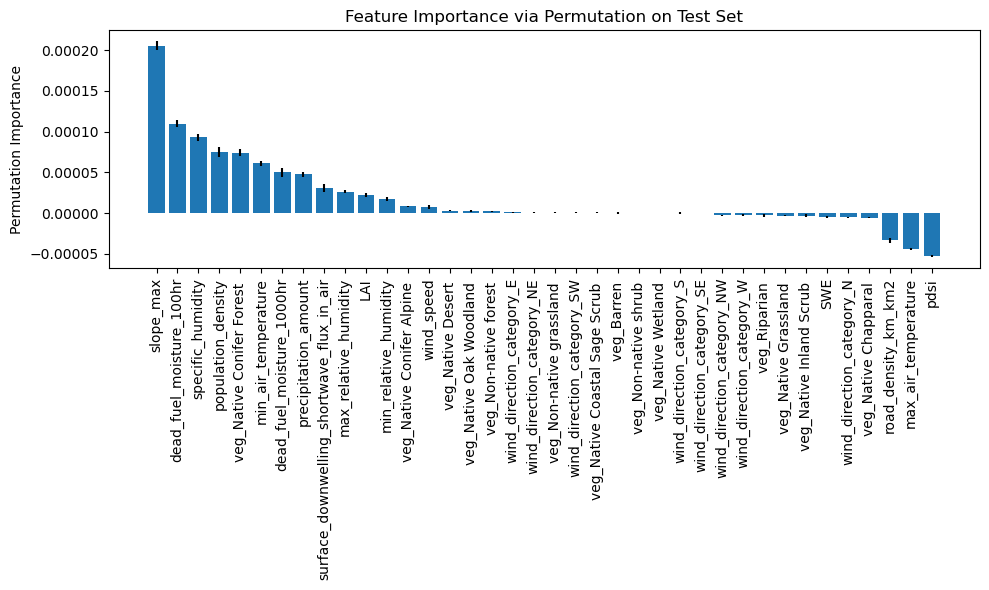

In [9]:
# Replace these with your actual model and test data
# xgb_model = your trained XGBoost model
X_test = Eval_data[features]
y_test = Eval_data['IS_FIRE']

# Calculate permutation importance
result = permutation_importance(loaded_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Extract importance and feature names
importances = result.importances_mean
std = result.importances_std
indices = np.argsort(importances)[::-1]
feature_names = X_test.columns

# Plot the permutation importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], yerr=std[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.ylabel("Permutation Importance")
plt.title("Feature Importance via Permutation on Test Set")
plt.tight_layout()
plt.show()

In [23]:
X_test = Eval_region_season_full[features]
y_test = Eval_region_season_full['IS_FIRE']

In [24]:
X_test.shape

(245076, 38)

In [25]:
import xgboost as xgb
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, average_precision_score
import numpy as np
import matplotlib.pyplot as plt

c:\Users\fangshuye\AppData\Local\anaconda3\envs\py311\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


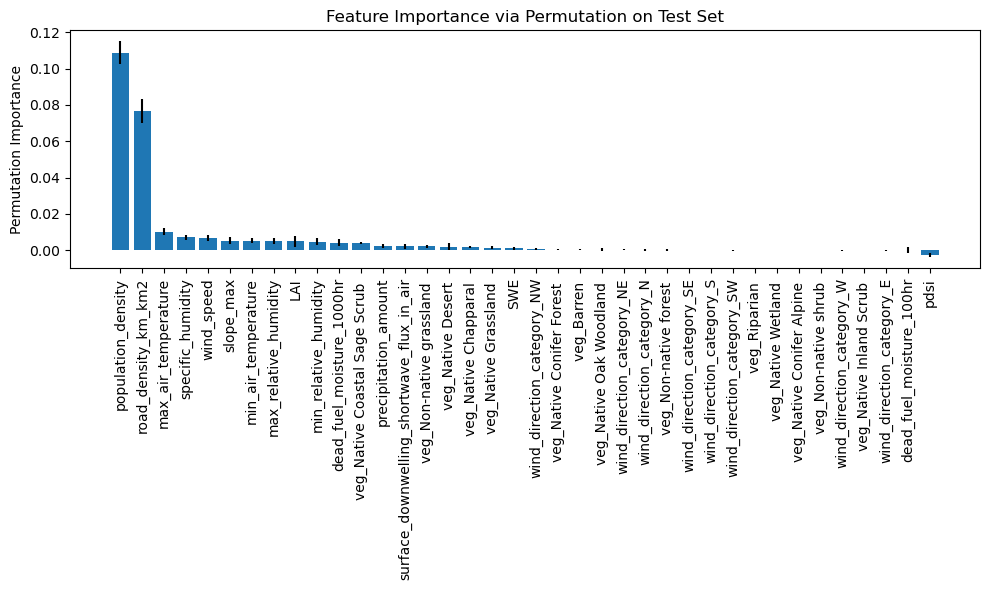

In [27]:
prp_auc_scorer = make_scorer(average_precision_score, needs_proba=True)

result = permutation_importance(loaded_model, X_test, y_test, scoring='roc_auc', n_repeats=10, random_state=42, n_jobs=-1)

# Extract importance and feature names
importances = result.importances_mean
std = result.importances_std
indices = np.argsort(importances)[::-1]
feature_names = X_test.columns

# Plot the permutation importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], yerr=std[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.ylabel("Permutation Importance")
plt.title("Feature Importance via Permutation on Test Set")
plt.tight_layout()
plt.show()

In [28]:
X_test = Eval_region_season_full[features]
y_test = Eval_region_season_full['IS_FIRE']

In [29]:
import xgboost as xgb
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume xgb_model is your trained XGBoost model
# Assume X_test is your test dataset as a DataFrame

# 1. Compute SHAP values
explainer = shap.Explainer(loaded_model)
shap_values = explainer(X_test)

# Mean absolute SHAP value per feature
shap_importance = np.abs(shap_values.values).mean(axis=0)
shap_importance_percent = 100 * shap_importance / shap_importance.sum()

shap_df = pd.DataFrame({
    'Feature': X_test.columns,
    'SHAP Importance (%)': shap_importance_percent
}).sort_values(by='SHAP Importance (%)', ascending=False)

In [30]:
# order by SHAP importance and only keep top 10 features
top_n = 10
shap_df_top = shap_df.head(top_n)

<Figure size 1000x600 with 0 Axes>

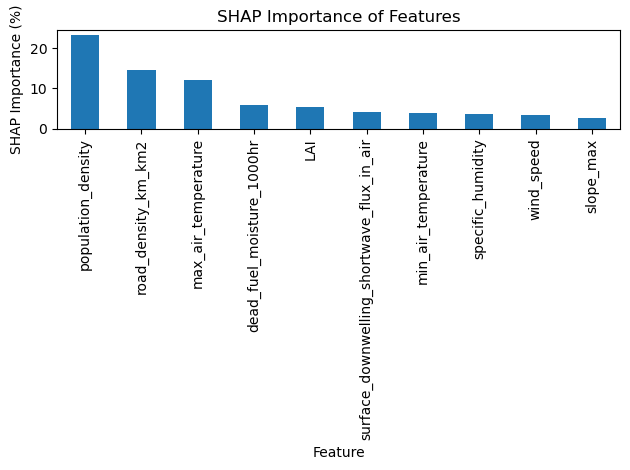

In [32]:
# plot the SHAP importance
plt.figure(figsize=(10, 6))
shap_df_top.plot(kind='bar', x='Feature', y='SHAP Importance (%)', legend=False)
plt.title('SHAP Importance of Features')
plt.ylabel('SHAP Importance (%)')
plt.tight_layout()
plt.show()
# close the plot
plt.close()

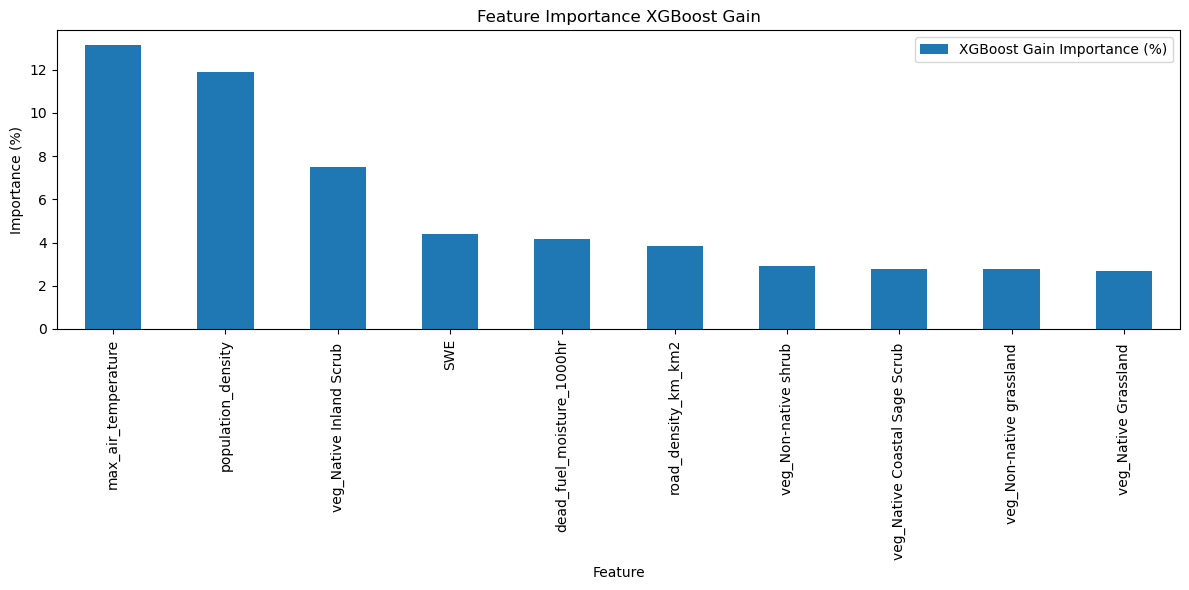

In [16]:
# 2. XGBoost built-in feature importance (gain)
booster = loaded_model.get_booster()
xgb_importance_dict = booster.get_score(importance_type='gain')

xgb_importance = np.array([xgb_importance_dict.get(f, 0.0) for f in X_test.columns])
xgb_importance_percent = 100 * xgb_importance / xgb_importance.sum()

xgb_df = pd.DataFrame({
    'Feature': X_test.columns,
    'XGBoost Gain Importance (%)': xgb_importance_percent
}).sort_values(by='XGBoost Gain Importance (%)', ascending=False)

# only keep top 10 features
top_n = 10
xgb_df = xgb_df.head(top_n)
# Plot
xgb_df.set_index('Feature').plot(kind='bar', figsize=(12, 6))
plt.ylabel('Importance (%)')
plt.title('Feature Importance XGBoost Gain')
plt.tight_layout()
plt.show()
plt.close()